# Noise2Void - 2D Example for BSD68 Data

The data used in this notebook is the same as presented in the paper.

In [ ]:
#@markdown ##Run this cell to check if you have GPU access
# %tensorflow_version 1.x


import tensorflow as tf
if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.') 
  print('Did you change your runtime ?') 
  print('If the runtime setting is correct then Google did not allocate a GPU for your session')
  print('Expect slow performance. To access GPU try reconnecting later')

else:
  print('You have GPU access')
  !nvidia-smi

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

Using TensorFlow backend.


In [ ]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

# Training Data Preparation

In [2]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/BSD68_reproducibility.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/pbj89sV6n6SyM29/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [3]:
X = np.load('data/BSD68_reproducibility_data/train/DCNN400_train_gaussian25.npy')
X_val = np.load('data/BSD68_reproducibility_data/val/DCNN400_validation_gaussian25.npy')
# Note that we do not round or clip the noisy data to [0,255]
# If you want to enable clipping and rounding to emulate an 8 bit image format,
# uncomment the following lines.
# X = np.round(np.clip(X, 0, 255.))
# X_val = np.round(np.clip(X_val, 0, 255.))

# Adding channel dimension
X = X[..., np.newaxis]
print(X.shape)
X_val = X_val[..., np.newaxis]
print(X_val.shape)

(3168, 180, 180, 1)
(4, 180, 180, 1)


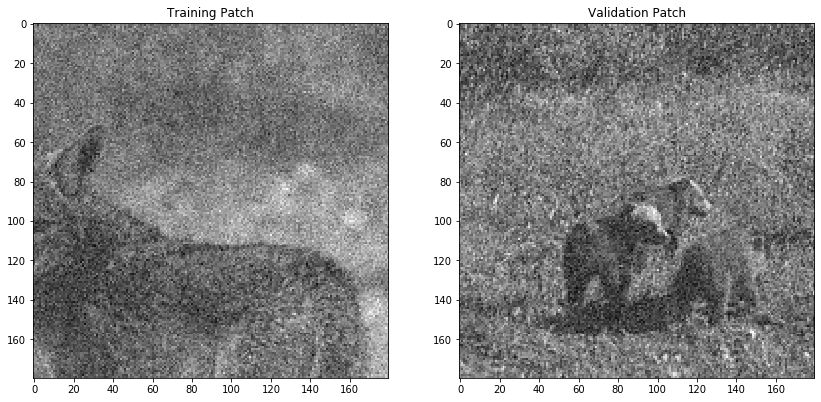

In [4]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='gray')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='gray')
plt.title('Validation Patch');

# Configure

In [5]:
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=400, train_epochs=200, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   unet_n_first = 96,
                   unet_residual = True,
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=2,
                   single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['110.72957232412905'],
 'stds': ['63.656060106500874'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 96,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 200,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 2,
 'single_net_per_channel': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [6]:
# a name used to identify the model
model_name = 'BSD68_reproducability_5x5'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)
model.prepare_for_training(metrics=())

/home/tbuchhol/Gitrepos/n2v/n2v/models/n2v_standard.py:428: UserWarning: output path for model already exists, files may be overwritten: /home/tbuchhol/Gitrepos/n2v/examples/2D/denoising2D_BSD68/models/BSD68_reproducability_5x5
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


# Training

Training the model will likely take some time. We recommend to monitor the progress with TensorBoard, which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard in a terminal from the current working directory with tensorboard --logdir=. Then connect to http://localhost:6006/ with your browser.

In [7]:
# We are ready to start training now.
history = model.train(X, X_val, 10, 20)

/home/tbuchhol/Gitrepos/n2v/n2v/models/n2v_standard.py:188: UserWarning: small number of validation images (only 0.1% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100*frac_val))
Preparing validation data: 100%|██████████| 4/4 [00:00<00:00, 350.06it/s]

8 blind-spots will be generated per training patch of size (64, 64).


Epoch 1/10
20/20 [==============================] - 14s 679ms/step - loss: 0.4832 - val_loss: 2.5607
Epoch 2/10
20/20 [==============================] - 7s 341ms/step - loss: 0.2406 - val_loss: 0.5315
Epoch 3/10
20/20 [==============================] - 7s 335ms/step - loss: 0.2304 - val_loss: 0.3726
Epoch 4/10
20/20 [==============================] - 7s 340ms/step - loss: 0.2264 - val_loss: 0.3239
Epoch 5/10
20/20 [==============================] - 7s 334ms/step - loss: 0.2223 - val_loss: 0.2887
Epoch 6/10
20/20 [==============================] - 7s 338ms/step - loss: 0.2157 - val_loss: 0.2965
Epoch 7/10
20/20 [==============================] - 7s 330ms/step - loss: 0.2154 - val_loss: 0.2835
Epoch 8/10
20/20 [==============================] - 7s 333ms/step - loss: 0.2150 - val_loss: 0.2841
Epoch 9/10
20/20 [==============================] - 7s 338ms/step - loss: 0.2156 - val_loss: 0.2842
Epoch 10/10
20/20 [==============================] - 7s 333ms/step - loss: 0.2151 - val_loss: 0.276

### After training, lets plot training and validation loss.

['loss', 'lr', 'val_loss']


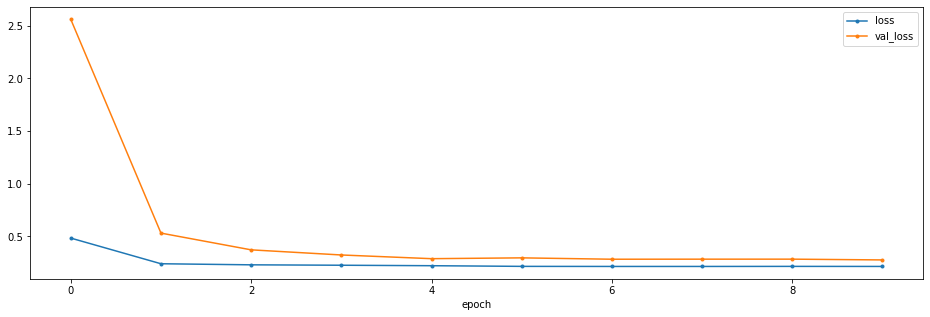

In [8]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

# Compute PSNR to GT

In [9]:
groundtruth_data = np.load('data/BSD68_reproducibility_data/test/bsd68_groundtruth.npy', allow_pickle=True)

In [10]:
test_data = np.load('data/BSD68_reproducibility_data/test/bsd68_gaussian25.npy', allow_pickle=True)
# Note that we do not round or clip the noisy data to [0,255]
# If you want to enable clipping and rounding to emulate an 8 bit image format,
# uncomment the following line.
# test_data = np.round(np.clip(test_data, 0, 255.))

In [11]:
def PSNR(gt, img):
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(255) - 10 * np.log10(mse)

In [12]:
# Weights corresponding to the smallest validation loss
# Smallest validation loss does not necessarily correspond to best performance, 
# because the loss is computed to noisy target pixels.
model.load_weights('weights_best.h5')

In [13]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX');
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

In [14]:
print("PSNR:", np.round(np.mean(psnrs), 2))

PSNR: 23.81


In [15]:
# The weights of the converged network. 
model.load_weights('weights_last.h5')

In [16]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX')
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

In [17]:
print("PSNR:", np.round(np.mean(psnrs), 2))

PSNR: 23.81
